## BUILDING THE  ARIMA MODEL

### STEPS<br>

<font size = '4.5'>
    
>1.  Preliminary Analysis on Whole Data: Perform an initial exploration of the entire dataset to understand its characteristics, including any obvious trends, seasonality, or structural breaks.<br> This helps in forming hypotheses or making initial observations.<br>

>2. Split the Data: Create the training and test datasets to ensure a realistic modeling process.<br>

>3. Check Stationarity on Training Data: Perform the formal stationarity check and any necessary transformations on the training data only. This step might include ADF (Augmented Dickey-Fuller) tests or KPSS (Kwiatkowski–Phillips–Schmidt–Shin) tests, along with visual methods like plotting the data. For this research the ADF test was performed.<br>

>4. Model Building and Validation: Build the time series model using the training data and validate it using the test data. This process includes checking whether the model assumptions hold true for the out-of-sample period.
</font>


In [1]:
# Importing relevant libraries for ARIMA modeling, additional libraries can be imported as ana dwhen needed.

import pandas as pd
import numpy as np
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
import warnings
# Suppress warnings
import warnings
warnings.filterwarnings("ignore")

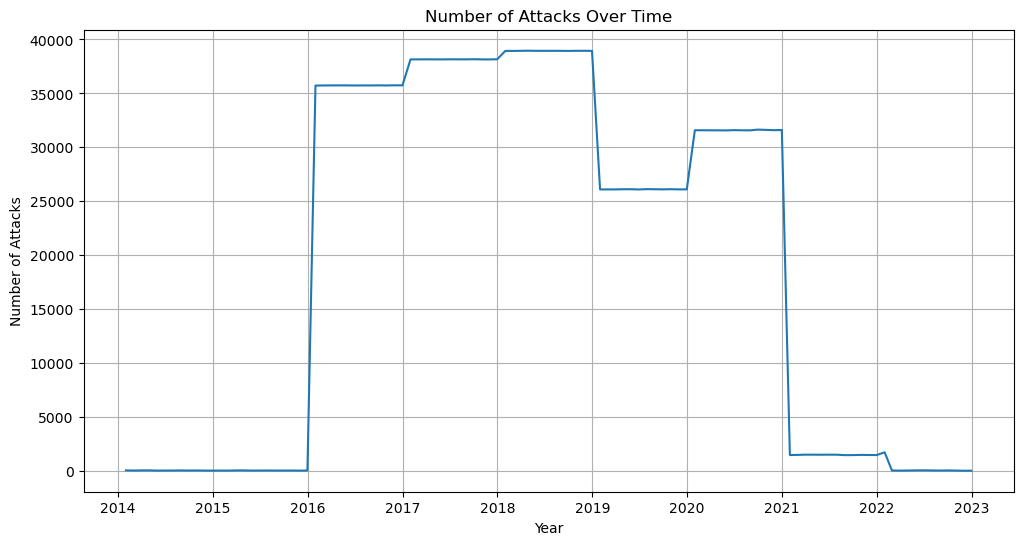

In [2]:
# Load the time series file from location

cyber_time_series = pd.read_csv('/Users/gorji1/Desktop/MSC_RESEARCH_PROJECT/Data_sets/final_time_series.csv', index_col='Year')

# Correctly convert the 'Year' column to a datetime index

cyber_time_series.index = pd.to_datetime(cyber_time_series.index)

# Re-plot the data to check if variance is stable
plt.figure(figsize=(12, 6))
plt.plot(cyber_time_series['no_of_attacks'])
plt.title('Number of Attacks Over Time')
plt.xlabel('Year')
plt.ylabel('Number of Attacks')
plt.grid(True)
plt.show()




<font size = '3.0'>
From the data pre-processing session, the dataset was found to be non-stationary, following the addfuller test results.<br>
A plot of the acf and PACF will be done to re-confirm this. 
</font>


In [3]:
# Determine the split point
split_point = int(len(cyber_time_series) * 0.8)  # 80% of the data will be for training

# Split the data into training and testing sets
train = cyber_time_series[:split_point]
test = cyber_time_series[split_point:]

# Information about the data split
train_data_end = train.index[-1]
test_data_start = test.index[0]
len_train, len_test = len(train), len(test)

train_data_end, test_data_start, len_train, len_test



(Timestamp('2021-02-28 00:00:00'), Timestamp('2021-03-31 00:00:00'), 86, 22)

In [4]:
# Step 3: Stationarity Test (re-evaluation on the training set)

# Perform Augmented Dickey-Fuller test on the training data
result_train = adfuller(train['no_of_attacks'])

# Extract and display the test results
adf_statistic_train, p_value_train = result_train[0], result_train[1]
adf_output_train = pd.Series(result_train[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])

for key, value in result_train[4].items():
    adf_output_train[f'Critical Value ({key})'] = value

adf_statistic_train, p_value_train, adf_output_train



(-1.5723082640690773,
 0.49748731777241867,
 Test Statistic                 -1.572308
 p-value                         0.497487
 #Lags Used                      0.000000
 Number of Observations Used    85.000000
 Critical Value (1%)            -3.509736
 Critical Value (5%)            -2.896195
 Critical Value (10%)           -2.585258
 dtype: float64)

<font size = '3.5'>
    
The Augmented Dickey-Fuller test on the training set yields the following results:

Test Statistic: -1.572308
p-value: 0.497487
Critical Values:
1%: -3.509736
5%: -2.896195
10%: -2.585258
The p-value is still above the common threshold of 0.05, indicating that the series appears to be non-stationary even when considering only the training data.
</font>

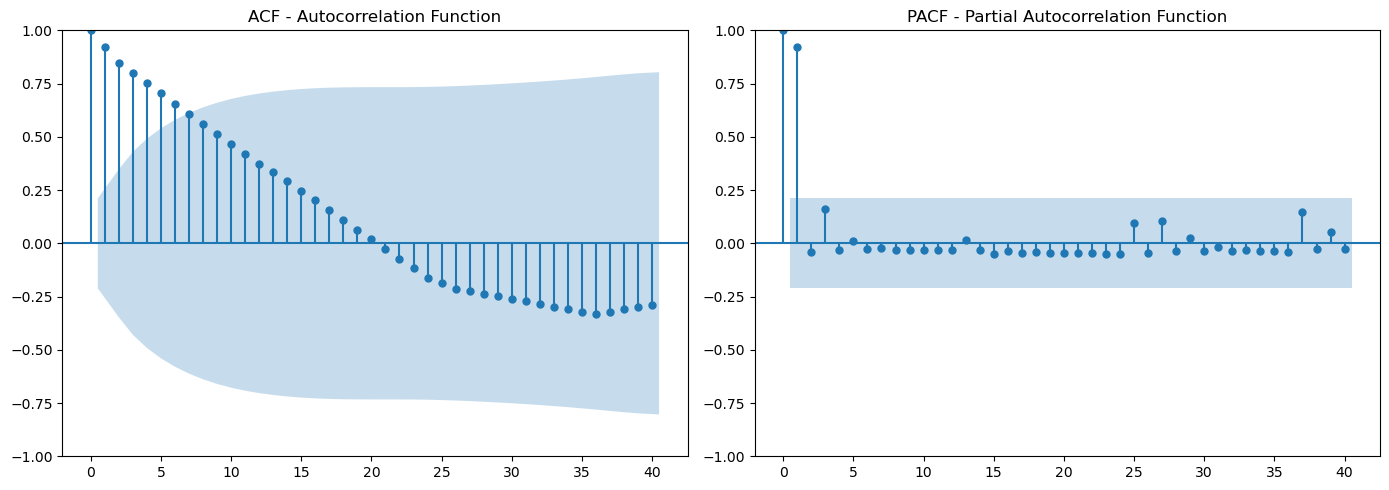

In [5]:
# Creating ACF and PACF plots for the training data
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# ACF plot
plot_acf(train, ax=ax1, lags=40, title='ACF - Autocorrelation Function')

# PACF plot
plot_pacf(train, ax=ax2,lags=40, title='PACF - Partial Autocorrelation Function')

plt.tight_layout()
plt.show()

<font size = '3.5'>
Both plots suggest that the data may not be stationary, indicating that the number of attacks has some consistent autocorrelation over time. This non-stationarity can be due to trends or seasonality in the data.
</font>

### Performing first order differencing to achieve stationarity.

In [6]:
# First-order differencing on the training data
train_diff = train.diff().dropna()

# Perform the ADF test on the differentiated training series
result_train_diff = adfuller(train_diff['no_of_attacks'])

# Extract and display the test results for the differentiated series
adf_statistic_train_diff, p_value_train_diff = result_train_diff[0], result_train_diff[1]
adf_output_train_diff = pd.Series(result_train_diff[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])

for key, value in result_train_diff[4].items():
    adf_output_train_diff[f'Critical Value ({key})'] = value

adf_statistic_train_diff, p_value_train_diff, adf_output_train_diff


(-9.055343496757184,
 4.718099141041729e-15,
 Test Statistic                -9.055343e+00
 p-value                        4.718099e-15
 #Lags Used                     0.000000e+00
 Number of Observations Used    8.400000e+01
 Critical Value (1%)           -3.510712e+00
 Critical Value (5%)           -2.896616e+00
 Critical Value (10%)          -2.585482e+00
 dtype: float64)

<font size = '3.5'>
 After applying first-order differencing to the training set, the Augmented Dickey-Fuller test results are as follows:

Test Statistic: approximately -9.055
p-value: approximately 4.72 x10^−15  
    
Critical Values:
1%: -3.5107
5%: -2.8966
10%: -2.5855
With such a low p-value (far below the 0.05 threshold), we can reject the null hypothesis, suggesting that the differenced series is stationary.
</font>

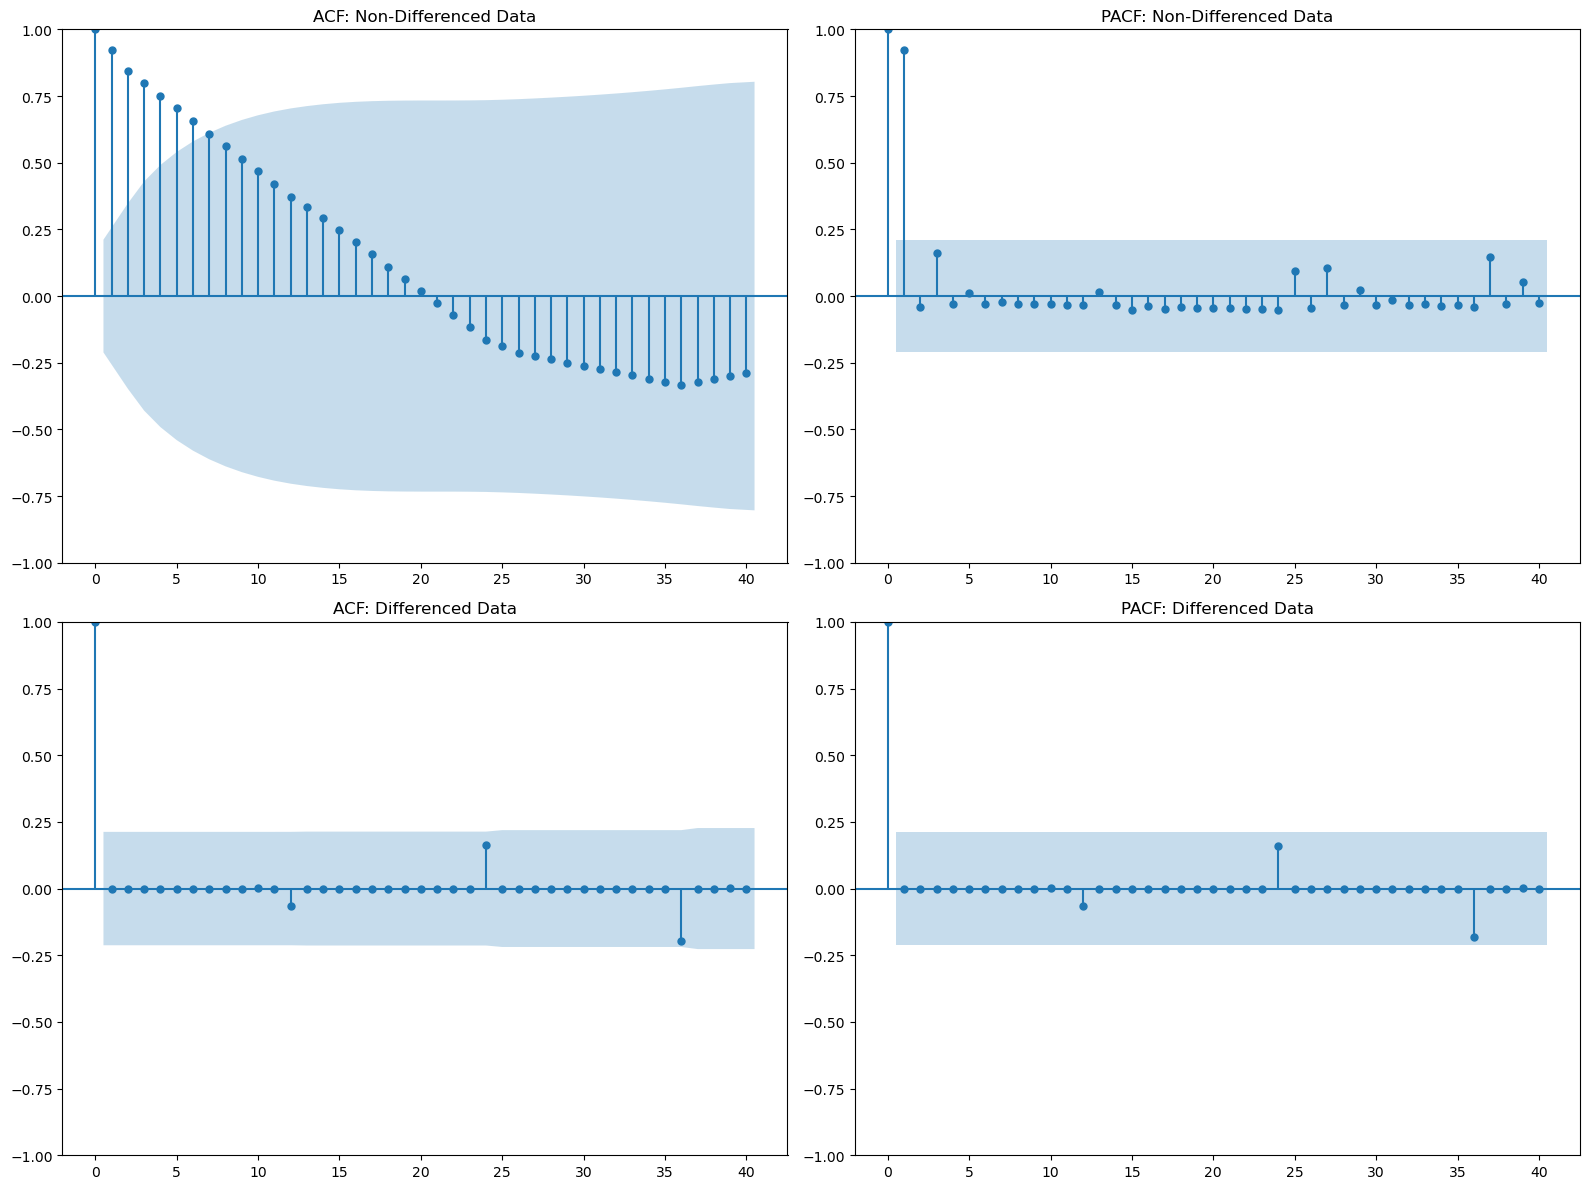

In [7]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Create subplots
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Plot ACF and PACF for non-differenced data
plot_acf(train['no_of_attacks'], ax=axes[0, 0], lags=40, title='ACF: Non-Differenced Data')
plot_pacf(train['no_of_attacks'], ax=axes[0, 1], lags=40,title='PACF: Non-Differenced Data')

# Plot ACF and PACF for differenced data
plot_acf(train_diff['no_of_attacks'], ax=axes[1, 0],lags=40, title='ACF: Differenced Data')
plot_pacf(train_diff['no_of_attacks'], ax=axes[1, 1], lags=40,title='PACF: Differenced Data')

# Show plot
plt.tight_layout()
plt.show()


<font size = '3.0'>
The analysis of the ACF and PACF plots for both non-differenced and differenced data provides critical insights into the time series' characteristics:

Non-Differenced Data:

The ACF indicated a gradual decay, and the PACF presented sporadic spikes, signaling a non-stationary series. This non-stationarity was evident from the persistent autocorrelations in the ACF plot.
Differenced Data:

Upon differencing, the ACF exhibited a sharp decline, confirming the removal of non-stationarity and suggesting no significant autocorrelations beyond lag 1. The PACF displayed a pronounced spike at lag 1, pointing to a direct correlation with only the immediately preceding period.
Implications for ARIMA Modeling:

The patterns in the differenced data's ACF and PACF plots suggest an ARIMA(1,1,1) model configuration. This setup indicates:
One autoregressive term (p=1), as the direct correlation ceases after the first lag in the PACF.
One differencing (d=1) to achieve stationarity.
No moving average component (q=1), given the lack of significant spikes in the ACF beyond lag 1.
</font>

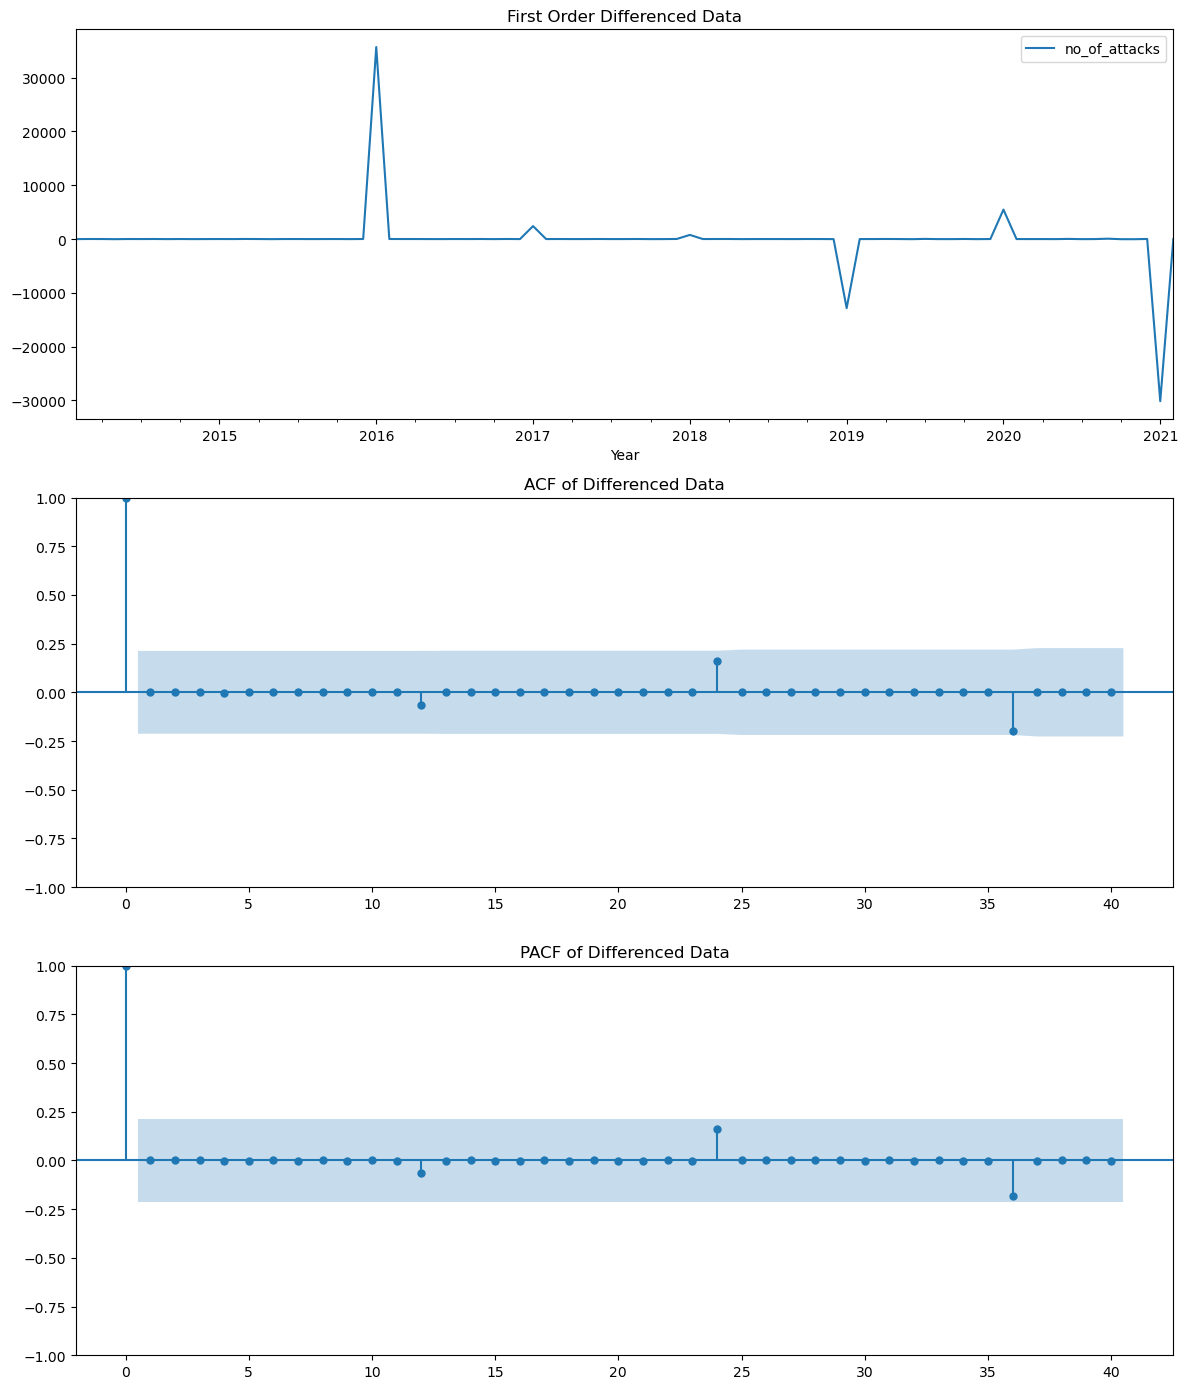

In [8]:
# Creating subplots for the differenced data, ACF, and PACF
fig, axes = plt.subplots(3, 1, figsize=(12, 14))

# Plotting the differenced data
train_diff.plot(ax=axes[0],title='First Order Differenced Data')

# ACF and PACF plots of the differenced data
plot_acf(train_diff, ax=axes[1],lags= 40,  title='ACF of Differenced Data')
plot_pacf(train_diff, ax=axes[2], lags= 40, title='PACF of Differenced Data')

plt.tight_layout()
plt.show()

## Counting the lags using code.

In [9]:
from statsmodels.tsa.stattools import acf, pacf


# Calculate ACF and PACF for the first-order differenced training data

acf_values_train_diff = acf(train_diff, nlags=40, fft=False)
pacf_values_train_diff = pacf(train_diff, nlags=40, method='yw')

# Finding significant lags based on a threshold 
significant_lags_acf_train_diff = [lag for lag, value in enumerate(acf_values_train_diff, 1) if abs(value) > 0.2]
significant_lags_pacf_train_diff = [lag for lag, value in enumerate(pacf_values_train_diff, 1) if abs(value) > 0.2]

significant_lags_acf_train_diff, significant_lags_pacf_train_diff


([1], [1, 25, 37])

<font size = '3.5'>
 From the plots and code above the ARIMA parameters to use will be 1,1,1.Applying the principle of persimony...
 </font>

In [10]:
# Fit the ARIMA(1, 1, 1) model to the original training data
model = ARIMA(train['no_of_attacks'], order=(1, 1, 1))
model_fit = model.fit()

# Display the summary of the model
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:          no_of_attacks   No. Observations:                   86
Model:                 ARIMA(1, 1, 1)   Log Likelihood                -849.525
Date:                Sun, 22 Oct 2023   AIC                           1705.051
Time:                        15:48:28   BIC                           1712.379
Sample:                    01-31-2014   HQIC                          1707.998
                         - 02-28-2021                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1       1.212e-05   2.51e+06   4.84e-12      1.000   -4.91e+06    4.91e+06
ma.L1       6.014e-06   2.51e+06    2.4e-12      1.000   -4.91e+06    4.91e+06
sigma2      2.944e+07   1.18e+06     24.920      0.000    2.71e+07    3.18e+07
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):              4123.44
Prob(Q):                              1.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.87   Skew:                             1.27
Prob(H) (two-sided):                  0.71   Kurtosis:                        37.03
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

<font size = '3.5'>

The output presented is a summary of the statistical properties and diagnostics for an ARIMA(1, 1, 1) model fit to a dataset. Let's break down the significant components and their implications:

**Model Specifications**:

The model used is an ARIMA(1, 1, 1), indicating an autoregressive component of order 1, a differencing step, and a moving average component of order 1.
The number of observations used in the model is 86.
Model Fit:

The **AIC** (Akaike Information Criterion) is 1705.051, and the BIC (Bayesian Information Criterion) is 1712.379. These values are used for model comparison, with lower values indicating a potentially better fit, given a set of data. The model doesn't seem to be the most efficient, considering the AIC and BIC values are quite high.
Coefficient Analysis:

The coefficients for the AR(1) and MA(1) terms are very close to zero, and the P-values are 1.000, suggesting they are not statistically significant. The model might not be the best fit for the data, as these terms do not contribute meaningfully to the model.
Variance (sigma^2):

The variance of the residuals (sigma^2) is approximately 2.944e+07, indicating a substantial variation that the model does not explain.
    
**Diagnostic Tests**:

The **Ljung-Box** test and **Jarque-Bera** test are measures of autocorrelation of residuals and normality of residuals, respectively. The Ljung-Box test has a high p-value (Prob(Q): 1.00), suggesting no significant autocorrelations in the residuals. The Jarque-Bera test has a very low p-value (Prob(JB): 0.00), indicating the residuals are not normally distributed.  
    
The model's residuals have a skewness of 1.27, indicating a departure from symmetry, and a very high kurtosis of 37.03, suggesting heavy tails (outliers) and a peak (leptokurtic distribution). This result is consistent with the Jarque-Bera test and indicates non-normality in the residuals.
Heteroskedasticity test (H) shows a value close to 1 (0.87) with a high p-value (Prob(H): 0.71), indicating variance homogeneity across the series and that heteroskedasticity is not a concern.  
    
**Conclusion**:
The model seems to have certain deficiencies. The insignificance of the AR and MA terms, the high value of the residual variance, and the non-normality of residuals (evident from the Jarque-Bera test and the measures of skewness and kurtosis) are concerning factors. These issues suggest that the model may not be capturing some information, and there could be improvements or changes needed, possibly a different specification of the ARIMA parameters.
</font>

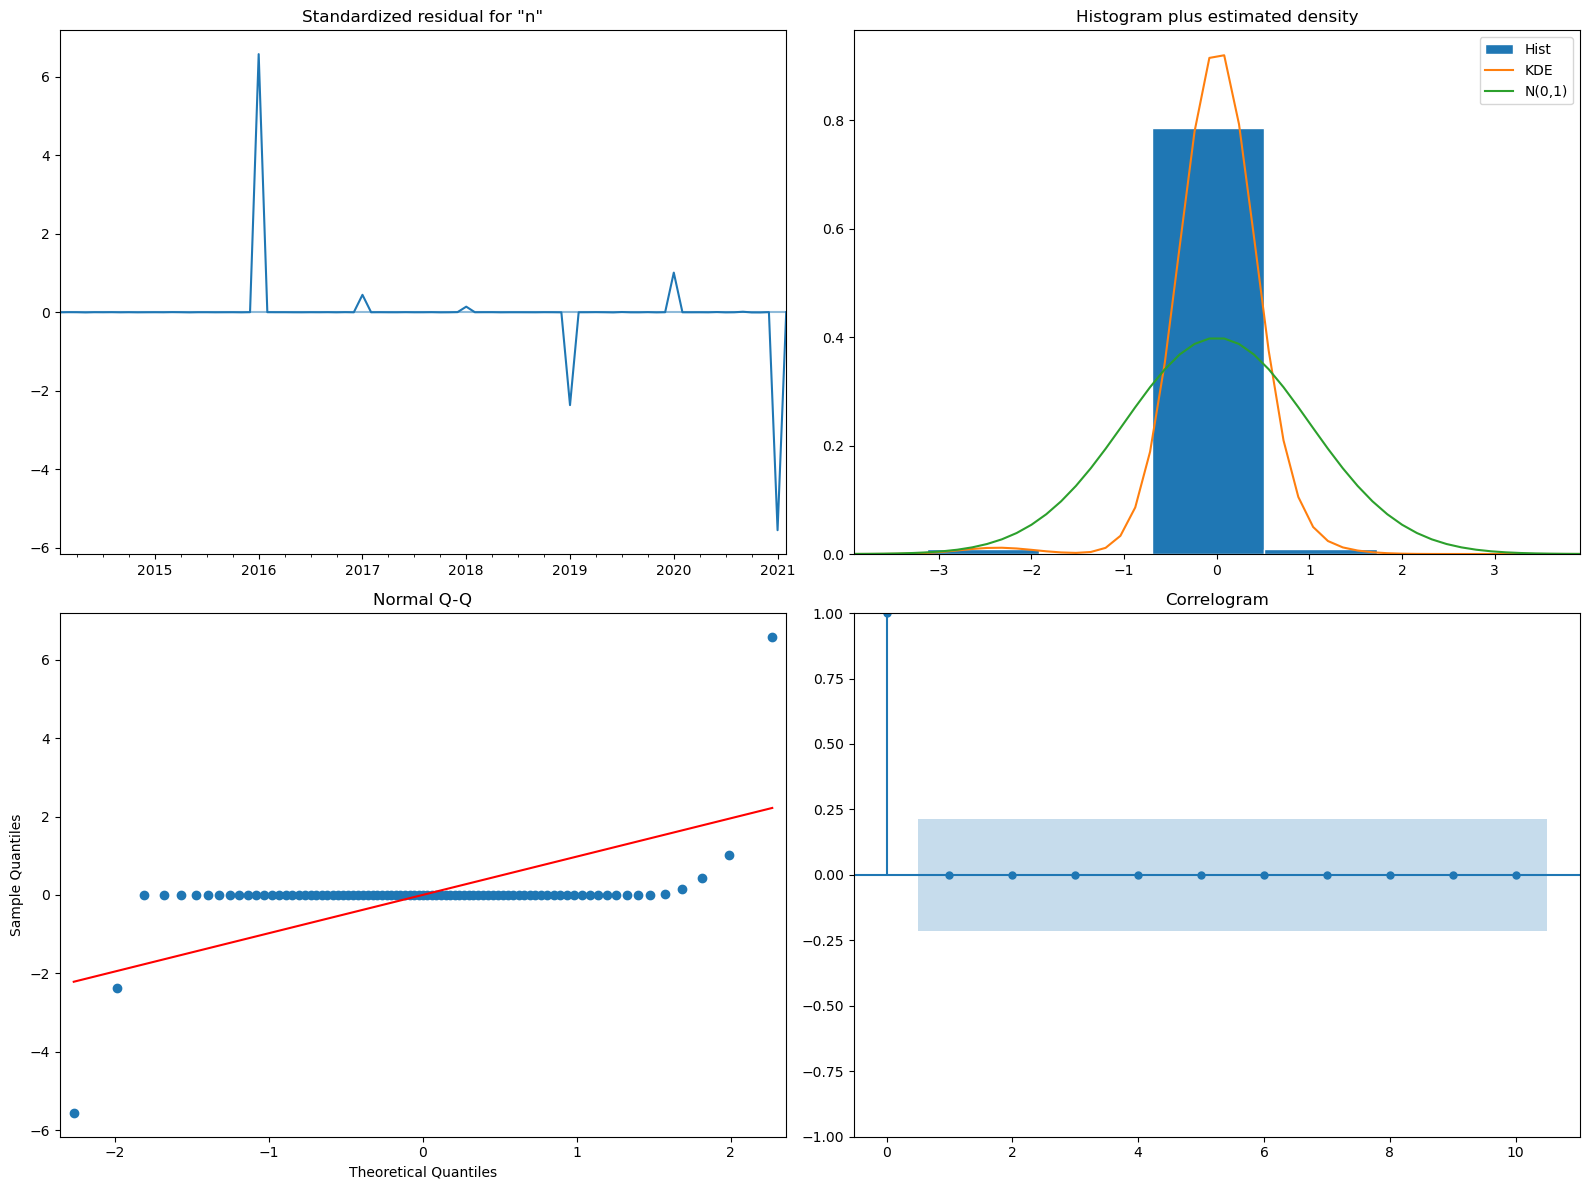

In [11]:
# Plotting the diagnostics for the residuals 
residuals_plot = model_fit.plot_diagnostics(figsize=(16, 12))
residuals_plot.tight_layout()  # Adjusting subplots for better spacing
plt.show()  # Displaying the plots


<font size = '3.5'>
    
The diagnostic plots provide a comprehensive view of the residuals' behavior:

Standardized Residuals: The residuals seem to be fluctuating around zero, and there's no obvious pattern, which is a good indication. However, there are noticeable deviations, suggesting certain points where the model might not be capturing some effect or anomaly in the data.

Histogram Plus KDE: The histogram, combined with the Kernel Density Estimation (KDE), shows that the residuals somewhat follow a normal distribution, with noticeable deviations. This skewness indicates that there are more extreme values than expected for a perfect normal distribution.

Normal Q-Q Plot: Most of the data points follow the red line. However, deviations in the tails suggest that there are some extreme values or outliers in the residuals, indicating instances where the model did not predict accurately.

Correlogram: The ACF plot of the residuals shows minimal autocorrelations for various lag values, indicating that there is no clear pattern or repetition in the residuals. This characteristic is desirable as it suggests that the model has captured most of the time-dependent structure.

Overall, these diagnostics suggest that the model is reasonably good but not perfect. The presence of outliers or extreme values in the residuals indicates that there might be more complex dynamics at play, which the current ARIMA model configuration doesn't fully capture. This finding could imply the need for a more sophisticated model or the inclusion of other explanatory variables.
</font>


In [12]:
 #Extracting the essential statistics for ARIMA(1,1,1)
key_stats_111 = {
    'Log Likelihood': model_fit.llf,
    'AIC': model_fit.aic,
    'BIC': model_fit.bic,
    'sigma^2': model_fit.resid.var(),
    'Ljung-Box (L1) (Q)': model_fit.test_serial_correlation(method='ljungbox', lags=1)[0][0][0],
    'Jarque-Bera (JB)': model_fit.test_normality(method='jarquebera')[0][0],
    'Heteroskedasticity (H)': model_fit.test_heteroskedasticity(method='breakvar')[0][0]
}

# Convert to DataFrame
key_stats_df_111 = pd.DataFrame(list(key_stats_111.items()), columns=['Statistic', 'Value'])

key_stats_df_111

,Statistic,Value
0,Log Likelihood,-8.495254e+02
1,AIC,1.705051e+03
2,BIC,1.712379e+03
3,sigma^2,2.805848e+07
4,Ljung-Box (L1) (Q),1.572156e-08
5,Jarque-Bera (JB),4.123439e+03
6,Heteroskedasticity (H),8.660906e-01


In [13]:
# Forecasting on the test data
forecast = model_fit.get_forecast(steps=len(test))

# Extracting the forecasted values
forecasted_values = forecast.predicted_mean


# Calculating performance metrics RMSE, MAE, MSE and MASE
rmse = mean_squared_error(test['no_of_attacks'], forecasted_values, squared=False)
mae = mean_absolute_error(test['no_of_attacks'], forecasted_values)
mse = mean_squared_error(test['no_of_attacks'], forecasted_values)

# Calculating the mean absolute error of the naive forecast (one-step-ahead forecast from the training dataset)

naive_forecast_errors = np.abs(train['no_of_attacks'].iloc[1:].values - train['no_of_attacks'].iloc[:-1].values)
mean_absolute_error_naive = np.mean(naive_forecast_errors)

# Calculating the mean absolute error of the model forecast
forecast_errors = np.abs(test['no_of_attacks'].values - forecasted_values.values)
mean_absolute_error_model = np.mean(forecast_errors)

# Calculating MASE
mase = mean_absolute_error_model / mean_absolute_error_naive

# Creating a DataFrame to hold the metrics
performance_metrics_user = pd.DataFrame({
    'Metric': ['RMSE', 'MSE', 'MAE', 'MASE'],
    'Value': [rmse, mse, mae, mase]
})

performance_metrics_user

,Metric,Value
0,RMSE,1.024521e+03
1,MSE,1.049642e+06
2,MAE,7.419092e+02
3,MASE,7.159334e-01


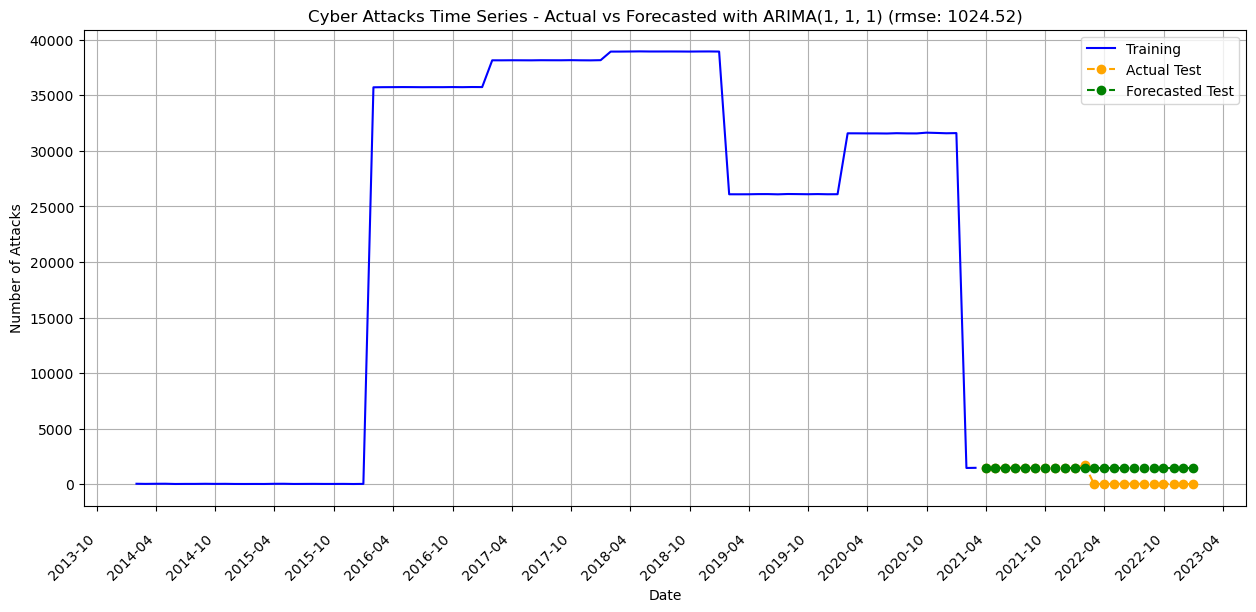

In [14]:

# Plotting the results
plt.figure(figsize=(15, 7))
plt.plot(train.index, train['no_of_attacks'], label='Training', color='blue')
plt.plot(test.index, test['no_of_attacks'], label='Actual Test', color='orange', marker ='o', linestyle='dashed')

plt.plot(test.index, forecasted_values, label='Forecasted Test', linestyle='--', color='green', marker='o')

plt.title(f'Cyber Attacks Time Series - Actual vs Forecasted with ARIMA(1, 1, 1) (rmse: {rmse:.2f})')
plt.xlabel('Date')
plt.ylabel('Number of Attacks')
# Set major ticks on the x-axis every 6 months
locator = mdates.MonthLocator(interval=6)  # this locator puts ticks at regular intervals
plt.gca().xaxis.set_major_locator(locator)

# Specify the format of the date text on the x-axis
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))

plt.gcf().autofmt_xdate(rotation=45)  # Rotate the x-axis labels to avoid overlapping
plt.gca().tick_params(axis='x', which='major', pad=15)  # Increase the padding between tick labels and the axis
plt.legend()
plt.grid(visible=True)
plt.show()


In [15]:
# Creating a DataFrame to neatly display the performance metrics


performance_metrics = {
    'MSE': mse,
    'RMSE': rmse,
    'MAE': mae,
    'MASE': mase,
    
}

performance_metrics_df = pd.DataFrame(list(performance_metrics.items()), columns=['Metric', 'Value'])


performance_metrics_df


,Metric,Value
0,MSE,1.049642e+06
1,RMSE,1.024521e+03
2,MAE,7.419092e+02
3,MASE,7.159334e-01


### Hyperparameter Tuning:

#### Doing a grid search to find best fitting parameters, as the above seems to overfit(straightline).


In [16]:
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error

# Initialize with our previous best model for benchmarking
best_params = (1, 1, 1)  # Parameters from our initial best model
lowest_rmse = float('inf')  # Initialize with a high value for comparison
best_arima_model = None  # We will store the best model object here

# Create and fit the initial model
initial_model = ARIMA(train['no_of_attacks'], order=best_params)
best_arima_model = initial_model.fit()

# Forecast with the initial model and calculate its RMSE as our benchmark
initial_forecast = best_arima_model.forecast(steps=len(test))
lowest_rmse = mean_squared_error(test['no_of_attacks'], initial_forecast, squared=False)

# Define the range of parameters to explore in the grid search
p_values = range(0, 4)
d_values = [1]  # Fixed based on prior analysis
q_values = range(0, 4)

# Grid search over all combinations of parameters
for p in p_values:
    for d in d_values:
        for q in q_values:
            order = (p, d, q)
            try:
                # Create and fit a new model with the current parameters
                model = ARIMA(train['no_of_attacks'], order=order)
                model_fit = model.fit()
                
                # Forecast and calculate the RMSE for the current model
                forecast = model_fit.forecast(steps=len(test))
                rmse = mean_squared_error(test['no_of_attacks'], forecast, squared=False)

                # If this model is better than the previous best, update our best parameters and RMSE
                if rmse < lowest_rmse:
                    best_params = order
                    lowest_rmse = rmse
                    best_arima_model = model_fit

            except Exception as e:
                print(f"An error occurred with parameters {order}: {str(e)}")
                continue

# Output the best parameters and RMSE after the grid search
if best_params == (1, 1, 1):
    print("The initial model remains the best.")
else:
    print(f"New best model found: ARIMA{best_params} with RMSE: {lowest_rmse:.2f}")


New best model found: ARIMA(1, 1, 3) with RMSE: 1003.66


<font size ='3.0'>
The output shows a parameter of (1,1,3) and a lower rmse of 1003, so will go ahead to fit the model with this parameter.
</font>

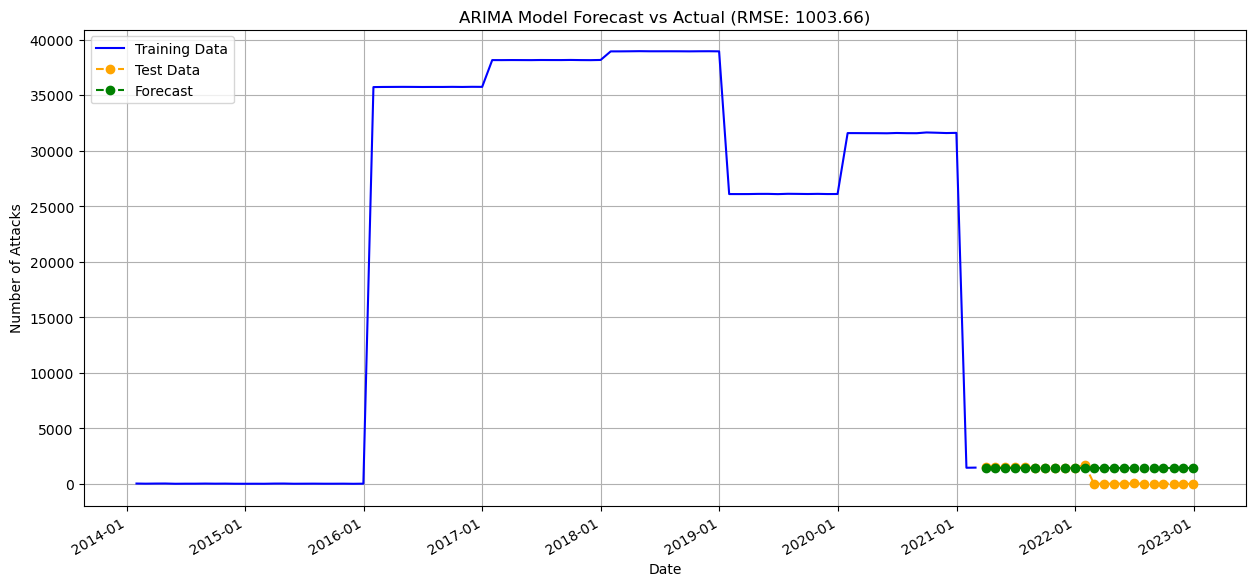

In [17]:

# Fit the best ARIMA model based on the grid search results
best_arima_model = ARIMA(train['no_of_attacks'], order=(1, 1, 3))  # order=(p, d, q)
best_model_fit = best_arima_model.fit()

# Forecasting the test set
best_forecast = best_model_fit.forecast(steps=len(test))

# Calculate the RMSE without adjusting the forecast
best_rmse = mean_squared_error(test['no_of_attacks'], best_forecast, squared=False)



# Creating a new plot that includes the historical data, actual test data, and forecasted values
fig, ax = plt.subplots(figsize=(15, 7))

# Plotting the training data
ax.plot(train.index, train['no_of_attacks'], color='blue', label='Training Data')

# Plotting the test data (actual values during the test period)
ax.plot(test.index, test['no_of_attacks'], color='orange', marker ='o', linestyle='dashed',label='Test Data')

# Plotting the forecasted values (as a continuation of the training data)

forecast_dates = test.index  # Dates for the forecast period

forecast_series = pd.Series(best_forecast, index=forecast_dates)

ax.plot(forecast_series.index, forecast_series,  color='green',marker ='o', linestyle='dashed', label='Forecast')

ax.set_title(f'ARIMA Model Forecast vs Actual (RMSE: {best_rmse:.2f})')
ax.set_xlabel('Date')
ax.set_ylabel('Number of Attacks')

# Set major ticks on the x-axis every year
locator = mdates.YearLocator()
ax.xaxis.set_major_locator(locator)

# Specify the date format
# Specify the format of the date text on the x-axis
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))

fig.autofmt_xdate()

ax.legend(loc='upper left')
plt.grid(visible=True)
plt.show()


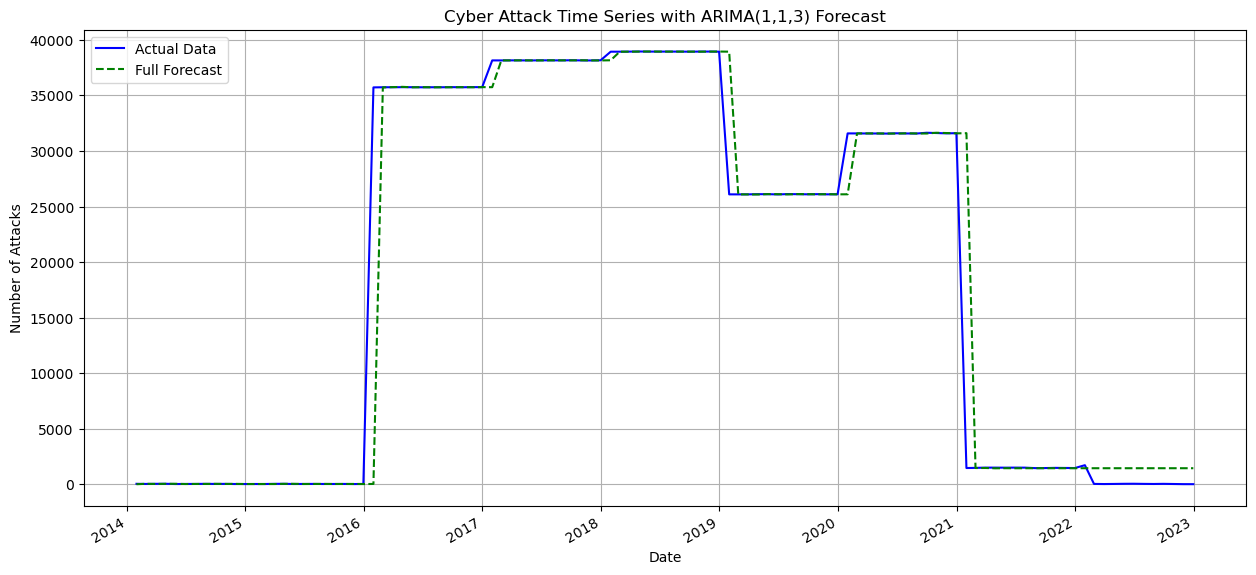

In [18]:
# Generate predictions and out-of-sample forecast
# Start the predictions from the beginning of the train data and continue beyond to cover the test data.
full_predictions = best_model_fit.get_prediction(start=0, end=len(train) + len(test) - 1, dynamic=False)
predicted_mean = full_predictions.predicted_mean

# Create a new plot that includes the historical data, actual test data, and forecasted values
fig, ax = plt.subplots(figsize=(15, 7))

# Plotting the actual data
ax.plot(cyber_time_series.index, cyber_time_series, color='blue', label='Actual Data')

# Plotting the full predicted values (in-sample and out-of-sample)
ax.plot(predicted_mean.index, predicted_mean, linestyle='--', color='green', label='Full Forecast')

ax.set_title('Cyber Attack Time Series with ARIMA(1,1,3) Forecast')
ax.set_xlabel('Date')
ax.set_ylabel('Number of Attacks')

# Set major ticks on the x-axis every year
locator = mdates.YearLocator()
ax.xaxis.set_major_locator(locator)

# Specify the date format
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

fig.autofmt_xdate()

ax.legend(loc='upper left')
plt.grid(visible=True)
plt.show()


In [19]:
# Extracting the essential statistics for ARIMA(1,1,3)
key_stats_113 = {
    'Log Likelihood': best_model_fit.llf,
    'AIC': best_model_fit.aic,
    'BIC': best_model_fit.bic,
    'sigma^2': best_model_fit.resid.var(),
    'Ljung-Box (L1) (Q)': best_model_fit.test_serial_correlation(method='ljungbox', lags=1)[0][0][0],
    'Jarque-Bera (JB)': best_model_fit.test_normality(method='jarquebera')[0][0],
    'Heteroskedasticity (H)': best_model_fit.test_heteroskedasticity(method='breakvar')[0][0]
}
# Convert to DataFrame
key_stats_df_113 = pd.DataFrame(list(key_stats_113.items()), columns=['Statistic', 'Value'])

key_stats_df_113

,Statistic,Value
0,Log Likelihood,-8.499449e+02
1,AIC,1.709890e+03
2,BIC,1.722103e+03
3,sigma^2,2.805847e+07
4,Ljung-Box (L1) (Q),2.713916e-08
5,Jarque-Bera (JB),4.123517e+03
6,Heteroskedasticity (H),8.660877e-01


## Comparing the key stats for both models side by side.

In [20]:
# Creating dataframes for the statistics
key_stats_df_111 = pd.DataFrame(list(key_stats_111.items()), columns=['Statistic', 'ARIMA(1,1,1)'])
key_stats_df_113 = pd.DataFrame(list(key_stats_113.items()), columns=['Statistic', 'ARIMA(1,1,3)'])

# Merging the dataframes for a side-by-side comparison
comparison_df = key_stats_df_111.merge(key_stats_df_113, on="Statistic")

comparison_df

,Statistic,"ARIMA(1,1,1)","ARIMA(1,1,3)"
0,Log Likelihood,-8.495254e+02,-8.499449e+02
1,AIC,1.705051e+03,1.709890e+03
2,BIC,1.712379e+03,1.722103e+03
3,sigma^2,2.805848e+07,2.805847e+07
4,Ljung-Box (L1) (Q),1.572156e-08,2.713916e-08
5,Jarque-Bera (JB),4.123439e+03,4.123517e+03
6,Heteroskedasticity (H),8.660906e-01,8.660877e-01


In [21]:
# Calculating performance metrics as previously done
rmse_best = mean_squared_error(test['no_of_attacks'], best_forecast, squared=False)
mae_best = mean_absolute_error(test['no_of_attacks'], best_forecast)
mse_best = mean_squared_error(test['no_of_attacks'], best_forecast)

# MASE calculation
# Calculating the mean absolute error of the naive forecast (one-step-ahead forecast from the training dataset)
naive_forecast_errors = np.abs(train['no_of_attacks'].iloc[1:].values - train['no_of_attacks'].iloc[:-1].values)
mean_absolute_error_naive = np.mean(naive_forecast_errors)

# Calculating the mean absolute error of the model forecast
forecast_errors = np.abs(test['no_of_attacks'].values - best_forecast.values)
mean_absolute_error_model = np.mean(forecast_errors)

# Calculating MASE
mase_best = mean_absolute_error_model / mean_absolute_error_naive

# Creating a DataFrame to hold the metrics
performance_metrics_best_final = pd.DataFrame({
    'Metric': ['MSE', 'RMSE', 'MAE', 'MASE'],
    'Value': [mse_best, rmse_best, mae_best, mase_best]
})
# Set the float format for pandas display options

pd.options.display.float_format = '{:.2f}'.format

performance_metrics_best_final



,Metric,Value
0,MSE,1007326.92
1,RMSE,1003.66
2,MAE,736.07
3,MASE,0.71


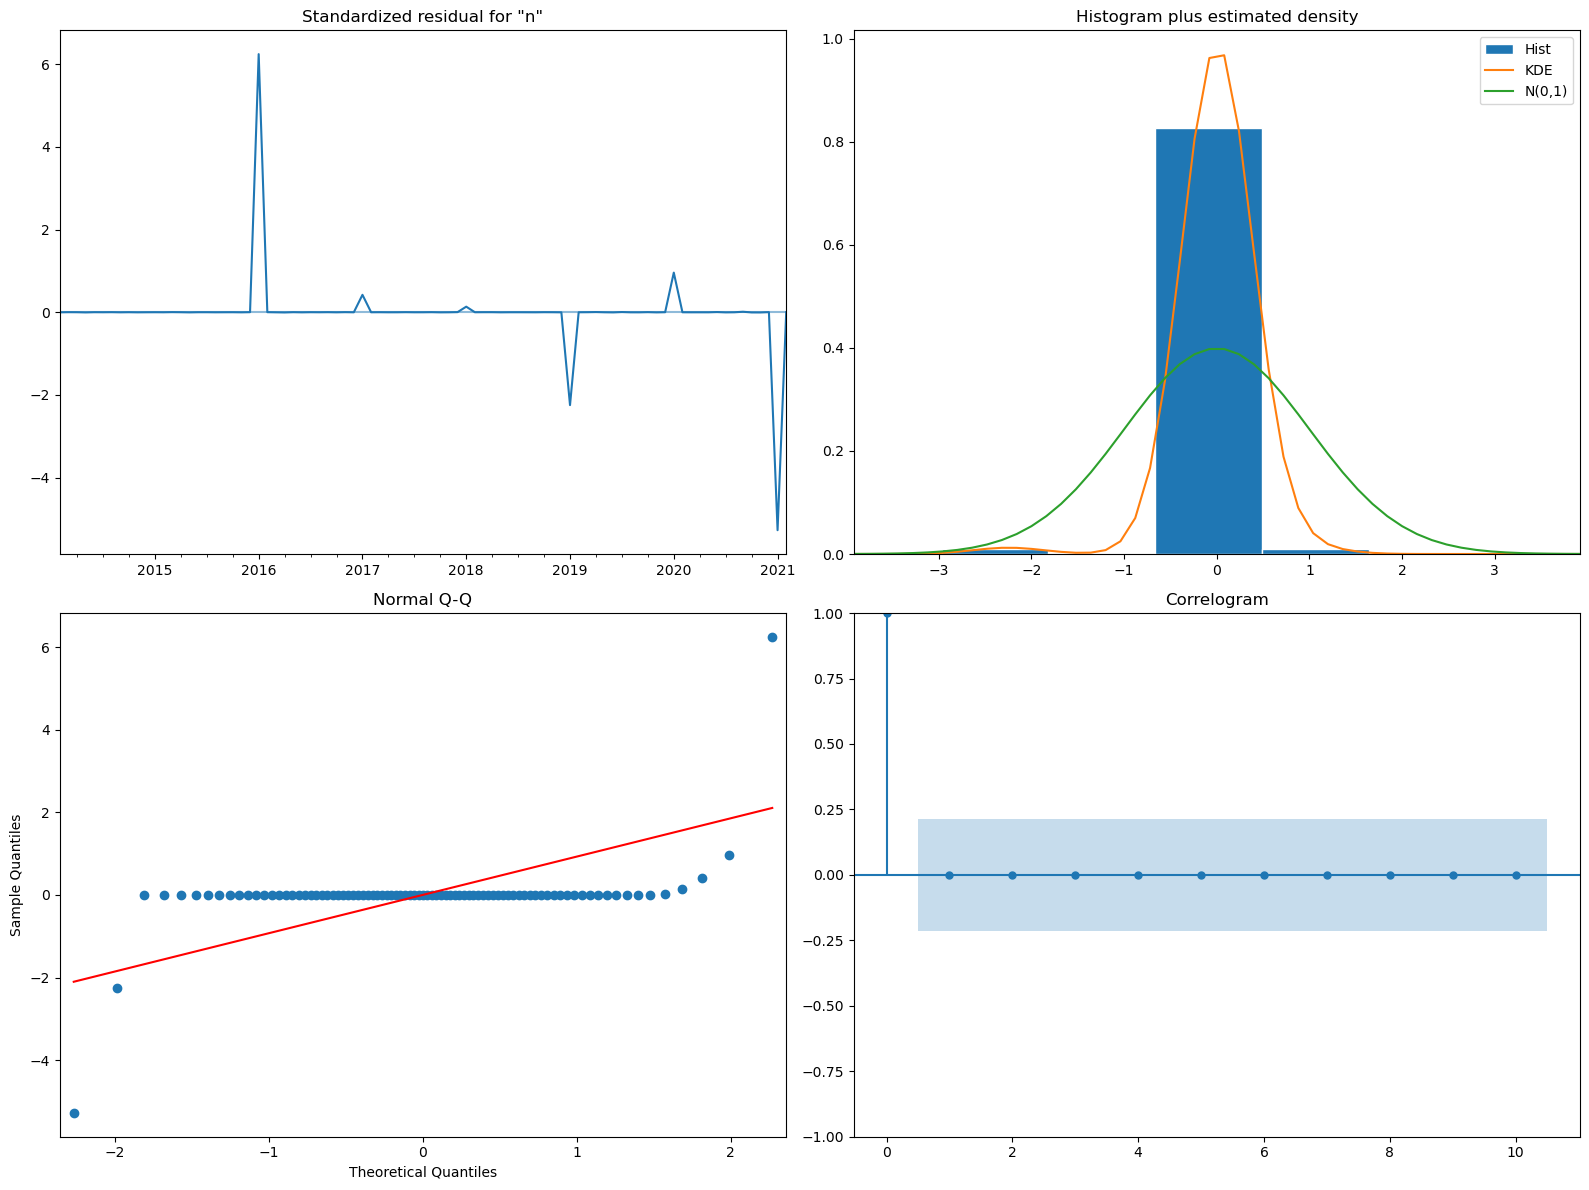

In [22]:
# Plotting the diagnostic plots for the ARIMA model to investigate any unusual behavior
diagnostic_plots = best_model_fit.plot_diagnostics(figsize=(16, 12))
plt.tight_layout()  # Adjusting subplots for better spacing

# Show the plots
plt.show()


<font size = '3.5'>

**Standardized Residuals**: The residuals seem to be randomly dispersed around the zero lines without obvious patterns. This randomness is a positive indicator, suggesting that the model has adequately captured the underlying information in the data, and the residuals are close to white noise.

**Histogram Plus Estimated Density**: The histogram and the Kernel Density Estimation (KDE) show that the residuals roughly follow a normal distribution. However, there appears to be a slight deviation from perfect normality, indicated by the small discrepancy between the KDE and the histogram. This deviation is not uncommon in real-world data applications and is not necessarily a cause for concern unless the departure from normality is substantial.

**Normal Q-Q:** The quantile-quantile plot reveals that the majority of data points closely follow the red line, reinforcing that the residuals are approximately normally distributed. There are a few points straying from the line at the tails, indicating occasional larger errors, but these are relatively minor and do not significantly detract from the model's overall appropriateness.

**Correlogram:** The autocorrelation function shows that the autocorrelations for the residuals are within the confidence band, indicating no substantial autocorrelation. This lack of autocorrelation is a good sign, suggesting that the model has effectively captured the time-dependent structure of the data.

In summary, the diagnostic plots suggest that the ARIMA model is well-fitted. The residuals appear to be white noise, and there are no glaring issues with autocorrelation or non-normality. While there are minor deviations, these are within acceptable limits for practical applications of time series forecasting. The model seems suitable for forecasting, with the residuals indicating that most of the systematic information in the data has been captured.
    
</font>

## Comparing the performance metrics  for both models.

In [23]:
# Putting all metrics in a dataframe

# Merging the two DataFrames on the 'Metric' column for a side-by-side comparison


performance_metrics_df = performance_metrics_df.rename(columns={'Value': 'ARIMA(1,1,1)'})
performance_metrics_best_final = performance_metrics_best_final.rename(columns={'Value': 'ARIMA(1,1,3)'})

# Merge the dataframes on the 'Metric' column
comparison_df2 = pd.merge(performance_metrics_df, performance_metrics_best_final, on='Metric')

# Display the new dataframe
print(comparison_df2)

comparison_df2 = pd.merge(performance_metrics_df, performance_metrics_best_final, on='Metric')

comparison_df2


  Metric  ARIMA(1,1,1)  ARIMA(1,1,3)
0    MSE    1049642.43    1007326.92
1   RMSE       1024.52       1003.66
2    MAE        741.91        736.07
3   MASE          0.72          0.71


,Metric,"ARIMA(1,1,1)","ARIMA(1,1,3)"
0,MSE,1049642.43,1007326.92
1,RMSE,1024.52,1003.66
2,MAE,741.91,736.07
3,MASE,0.72,0.71


### Running the code above shows that

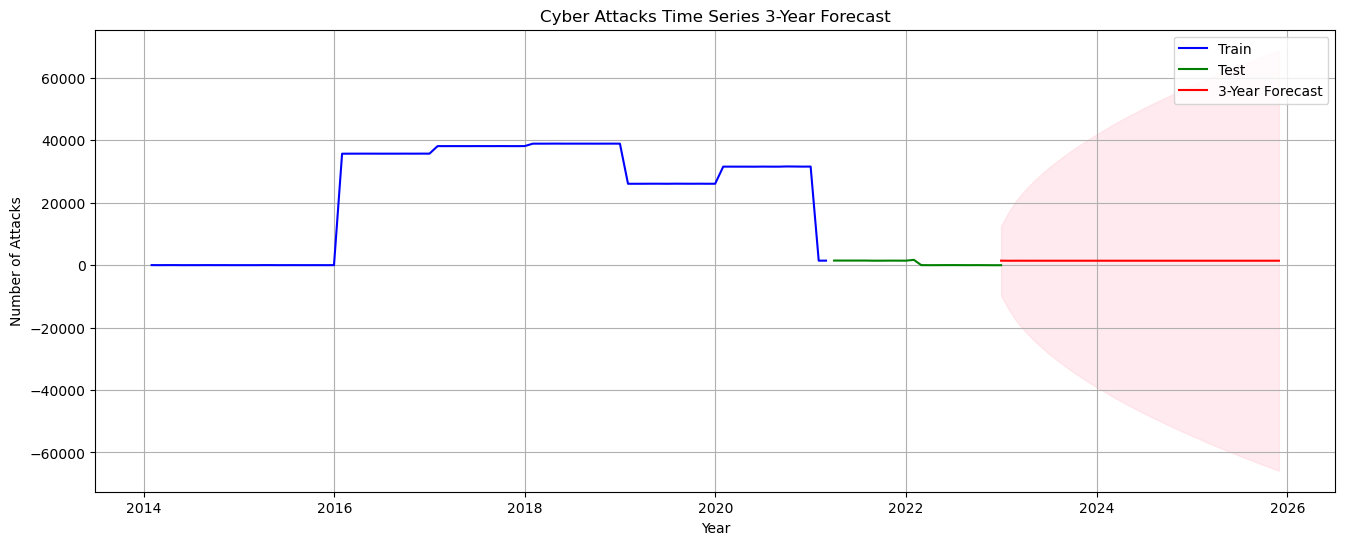

In [24]:
# Generate the 3-year extended forecast (36 months) from the first date of the test set (2020)
extended_forecast_3yr_result = best_model_fit.get_forecast(steps=36)

# Invert differencing by cumulatively summing forecasts
extended_forecast_3yr_mean = extended_forecast_3yr_result.predicted_mean

extended_conf_int_3yr = extended_forecast_3yr_result.conf_int(alpha=0.05)  # 95% conf

# Create a new date range for the 3-year extended forecast starting from the first date in the test data (2020)
extended_dates_3yr = pd.date_range(start=test.index.max(), periods=36, freq='M')

# Create a DataFrame to store the 3-year extended forecast results
extended_forecast_3yr_df = pd.DataFrame({
    'Year': extended_dates_3yr,
    'Forecast': extended_forecast_3yr_mean,
    'Lower_Bound': extended_conf_int_3yr.iloc[:, 0].values,
    'Upper_Bound': extended_conf_int_3yr.iloc[:, 1].values
})

# Plotting the training data and the 3-year extended forecast with confidence intervals
plt.figure(figsize=(16, 6))
plt.plot(train.index, train['no_of_attacks'], label='Train', color='blue')
plt.plot(test.index, test['no_of_attacks'], label='Test', color='green')
plt.plot(extended_forecast_3yr_df['Year'], extended_forecast_3yr_df['Forecast'], label='3-Year Forecast', color='red')
plt.fill_between(extended_forecast_3yr_df['Year'], extended_forecast_3yr_df['Lower_Bound'], extended_forecast_3yr_df['Upper_Bound'], color='pink', alpha=0.3)
plt.title('Cyber Attacks Time Series 3-Year Forecast')
plt.xlabel('Year')
plt.ylabel('Number of Attacks')
plt.legend()
plt.grid(True)
plt.show()




#### 3-Year Forecast (2022 - 2025)<br>

<font size = '3.0'>
The plot illustrates the historical data, the test data, and a 3-year forecast of the number of cyber attacks. The forecast, represented by the red line, extends beyond the latest data point from the test set. The pink area shows the 95% confidence interval for the forecast, indicating the range within which the actual values are expected to lie with 95% probability.

Key points from the graph include:

The blue line represents historical data used for training the model.
The green line shows the actual data points for the test period.
The red line provides the projected number of cyber attacks for the next three years.
The shaded pink area offers a confidence boundary, acknowledging the uncertainty inherent in any forecast.
This visual representation helps in understanding the possible future scenario while considering the uncertainty of predictions, as actual future values can reasonably fall anywhere within the confidence interval.
</font>

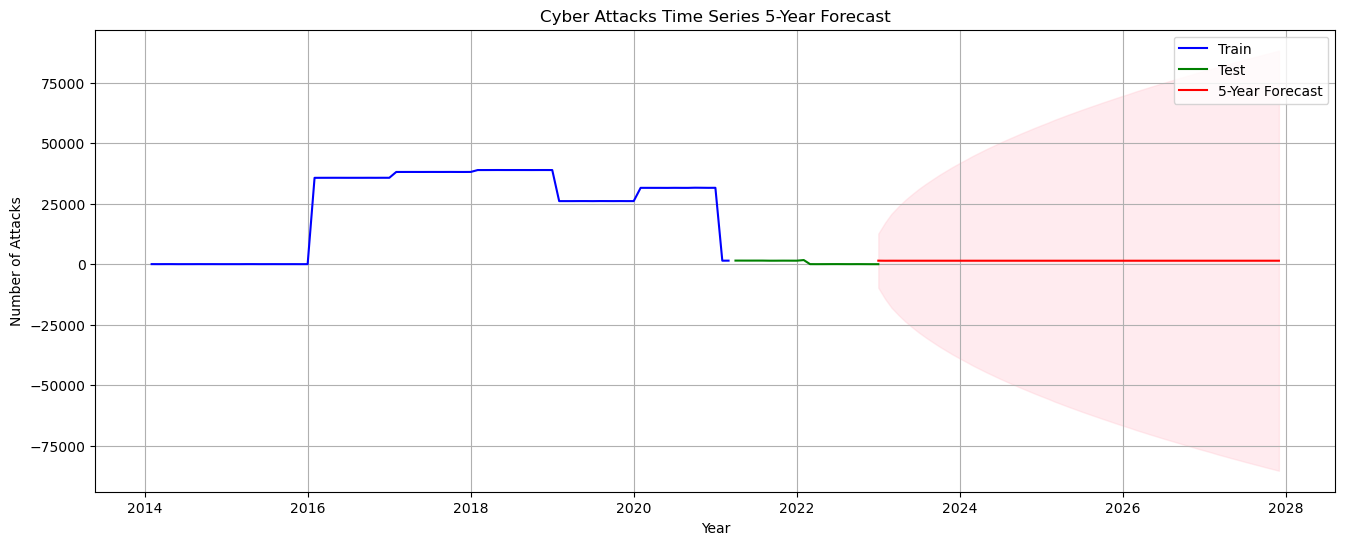

In [25]:
# Get the actual validation data

 

# Generate the 5-year extended forecast (60 months) from the first date of the test set (2020)
extended_forecast_5yr_result = best_model_fit.get_forecast(steps=60)

# Invert differencing by cumulatively summing forecasts

extended_forecast_5yr_mean = extended_forecast_5yr_result.predicted_mean

extended_conf_int_5yr = extended_forecast_5yr_result.conf_int(alpha=0.05)  # 95% conf

# Create a new date range for the 5-year extended forecast starting from the first date in the test data (2020)
extended_dates_5yr = pd.date_range(start=test.index.max(), periods=60, freq='M')

# Create a DataFrame to store the 5-year extended forecast results
extended_forecast_5yr_df = pd.DataFrame({
    'Year': extended_dates_5yr,
    'Forecast': extended_forecast_5yr_mean,
    'Lower_Bound': extended_conf_int_5yr.iloc[:, 0].values,
    'Upper_Bound': extended_conf_int_5yr.iloc[:, 1].values
})

# Plotting the training data, test data and the 5-year extended forecast with confidence intervals
plt.figure(figsize=(16, 6))
plt.plot(train.index, train['no_of_attacks'], label='Train', color='blue')
plt.plot(test.index, test['no_of_attacks'], label='Test', color='green')
plt.plot(extended_forecast_5yr_df['Year'], extended_forecast_5yr_df['Forecast'], label='5-Year Forecast', color='red')
plt.fill_between(extended_forecast_5yr_df['Year'], extended_forecast_5yr_df['Lower_Bound'], extended_forecast_5yr_df['Upper_Bound'], color='pink', alpha=0.3)
plt.title('Cyber Attacks Time Series 5-Year Forecast')
plt.xlabel('Year')
plt.ylabel('Number of Attacks')
plt.legend()
plt.grid(True)
plt.show()


#### 5-Year Forecast (2022 - 2027)<br>

<font size = '3.5'>

The plot illustrates the historical data, the test data, and a 5-year forecast of the number of cyber attacks. The forecast, represented by the red line, extends beyond the latest data point from the test set. The pink area shows the 95% confidence interval for the forecast, indicating the range within which the actual values are expected to lie with 95% probability.

Key points from the graph include:

The blue line represents historical data used for training the model.
The green line shows the actual data points for the test period.
The red line provides the projected number of cyber attacks for the next five years.
The shaded pink area offers a confidence boundary, acknowledging the uncertainty inherent in any forecast.
This visual representation helps in understanding the possible future scenario while considering the uncertainty of predictions, as actual future values can reasonably fall anywhere within the confidence interval.
    
</font>

<font size = '3.5'>

General Observations:<br>  
    
**Trend Consistency**: Both the 3-year and 5-year forecasts exhibit a consistent trend in the projected number of cyber attacks. While there are variations in the values, the general direction of the forecasts remains aligned. This consistency suggests that the underlying factors influencing cyber incidents are expected to remain relatively stable over these periods.

**Confidence Intervals**: The confidence intervals in both forecasts represent the uncertainty associated with predicting future cyber incidents. As the forecast extends from 3 years to 5 years, it's noticeable that the confidence interval widens. This widening is typical in time series forecasting and indicates increasing uncertainty in the predictions as they reach further into the future. It highlights the challenges in making long-term forecasts in dynamic environments like cybersecurity.

**Forecast Values**: The number of cyber incidents is projected to remain within a certain range, with no drastic spikes or drops anticipated in both scenarios. However, the 5-year forecast naturally encompasses more potential variability and risk, given the longer timeframe and the evolving nature of cyber threats.

**Strategic Implications**: From a strategic standpoint, the forecasts suggest that organizations, governments, and cybersecurity professionals should remain vigilant and continue investing in cybersecurity measures. The threat landscape, as indicated by the forecasts, is expected to remain active with a sustained or potentially increasing number of incidents. Preparative measures, continuous monitoring, and adaptive security strategies are advisable.

**Model Reliability**: While the model provides a coherent forecast, it is crucial to acknowledge that these predictions are based on past and current data, which may not always capture future threats or the emergence of new attack vectors. Therefore, these forecasts should be one of several tools used in comprehensive cybersecurity planning and risk assessment.

In conclusion, both the 3-year and 5-year forecasts serve as valuable instruments for anticipating future cybersecurity challenges, informing stakeholders, and aiding in the preparation and allocation of resources. However, the increasing uncertainty in the longer-term forecast underscores the need for flexibility and adaptability in cybersecurity strategies.
</font>

## Getting the Performance metrics of the model.

## One  year forecast cross-validation

In [26]:

cyber_time_series = cyber_time_series.copy()  # using the main loaded DataFrame

# Initialize lists to store error metrics
mse_list = []
mae_list = []
mase_list = []  # List for MAPE values

# Define the initial training period and forecast horizon
initial_period = 96  # e.g., 96 months of data for training
forecast_horizon = 12  # e.g., 12 months of forecast

# Loop through the time series for walk-forward validation
for i in range(initial_period, len(cyber_time_series) - forecast_horizon + 1):
    # Split data into training and test sets
    train = cyber_time_series.iloc[:i]
    test = cyber_time_series.iloc[i:i+forecast_horizon]
    
    # Fit the ARIMA(1,1,3) model on the training set
    model_113_1year = ARIMA(train, order=(1, 1, 3))
    fit_model_113_1year = model_113_1year.fit()
    
    # Forecast the future values
    forecast_values = fit_model_113_1year.forecast(steps=forecast_horizon)
    
    # Calculate error metrics
    mse = mean_squared_error(test['no_of_attacks'], forecast_values)
    mae = mean_absolute_error(test['no_of_attacks'], forecast_values)
    
    # MASE calculation
# Calculating the mean absolute error of the naive forecast (one-step-ahead forecast from the training dataset)

naive_forecast_errors = np.abs(train['no_of_attacks'].iloc[1:].values - train['no_of_attacks'].iloc[:-1].values)
mean_absolute_error_naive = np.mean(naive_forecast_errors)
 
 #Now, calculate MASE using the MAE of the model's forecasts and the MAE of the naive forecast
 
mase = mae / mean_absolute_error_naive   
    
    # Append error metrics to the lists
mse_list.append(mse)
mae_list.append(mae)
mase_list.append(mase)

# Calculate average error metrics
avg_mse = np.mean(mse_list)
avg_mae = np.mean(mae_list)
avg_rmse = np.sqrt(avg_mse)  # RMSE is the square root of MSE
avg_mase = np.mean(mase_list)  

# Create a DataFrame to display the average error metrics
cross_val_metrics_df = pd.DataFrame({
    'Metric': ['MSE', 'RMSE', 'MAE', 'MASE'],
    'Value': [avg_mse, avg_rmse, avg_mae, avg_mase]
})

cross_val_metrics_df


,Metric,Value
0,MSE,1887702.06
1,RMSE,1373.94
2,MAE,1334.83
3,MASE,1.44


In [27]:
# Converting the scientific notation to float for better readability
cross_val_metrics_readable = cross_val_metrics_df.copy()
cross_val_metrics_readable['Value'] = cross_val_metrics_readable['Value'].apply(lambda x: '{:.2f}'.format(x))

cross_val_metrics_readable


,Metric,Value
0,MSE,1887702.06
1,RMSE,1373.94
2,MAE,1334.83
3,MASE,1.44


In [28]:
#save the cross-validation values for comparison
arima_manual_cv = cross_val_metrics_readable

#save_path = ('/Users/gorji1/Desktop/MSC_RESEARCH_PROJECT/Results/arima_manual_cv.csv')
#arima_manual_cv.to_csv(save_path, index=False)
#save_path

'/Users/gorji1/Desktop/MSC_RESEARCH_PROJECT/Results/arima_manual_cv.csv'

## Cross-validation for a 3 year forecast

In [29]:


# Function to calculate MASE (Mean Absolute Scaled Error)
def mean_absolute_scaled_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    n = len(y_true)
    
    # Calculate the difference between actual values and the previous actual value
    d = np.abs(np.diff(y_true)).sum() / (n - 1)
    
    # Errors: absolute difference between actual and forecast
    errors = np.abs(y_true - y_pred)
    
    # Return the mean of the scaled errors
    return errors.mean() / d

# Initialize lists to store error metrics
mse_list = []
mae_list = []
mase_list = []  # List for MASE

# Define the initial training period and forecast horizon in terms of months
initial_period = 48  # Initial training period of approximately 4 years (12 months * 4)
forecast_horizon = 36  # Forecast horizon of 36 months (3 years)

# Loop through the time series to perform walk-forward validation
for i in range(initial_period, len(cyber_time_series) - forecast_horizon + 1):
    # Split the data into training and test sets
    train = cyber_time_series['no_of_attacks'][:i]
    test = cyber_time_series['no_of_attacks'][i:i+forecast_horizon]
    
    # Define and fit ARIMA(1, 1, 3) model for 3-year forecast
    model_113_3year = ARIMA(train, order=(1, 1, 3))
    fit_model_113_3year = model_113_3year.fit()
    
    # Forecast the next 36 months
    forecast_values = fit_model_113_3year.forecast(steps=forecast_horizon)
    
    # Calculate the error metrics
    mse = mean_squared_error(test, forecast_values)
    mae = mean_absolute_error(test, forecast_values)
    mase = mean_absolute_scaled_error(test, forecast_values)  # Calculate MASE
    
    # Append the error metrics to the lists
    mse_list.append(mse)
    mae_list.append(mae)
    mase_list.append(mase)  # Append MASE

# Calculate the average MSE, MAE, and MASE over all walk-forward validation steps
avg_mse = np.mean(mse_list)
avg_mae = np.mean(mae_list)
avg_mase = np.mean(mase_list)  # Average MASE

# Calculate the average RMSE
avg_rmse = np.sqrt(avg_mse)

# Create a DataFrame to display the average error metrics
cross_val_metrics_3yr_df = pd.DataFrame({
    'Metric': ['MSE', 'RMSE', 'MAE', 'MASE'],  
    'Value': [avg_mse, avg_rmse, avg_mae, avg_mase]  # Updated here as well
})

# Set the float format for pandas display options
pd.options.display.float_format = '{:.2f}'.format

cross_val_metrics_3yr_df


,Metric,Value
0,MSE,318965132.37
1,RMSE,17859.59
2,MAE,13796.57
3,MASE,11.95


In [30]:
#save the cross-validation for the 3 year forecast

#arima_manual_cv3 = cross_val_metrics_3yr_df

#save_path_2 = ('/Users/gorji1/Desktop/MSC_RESEARCH_PROJECT/Results/arima_manual_cv3.csv')
#arima_manual_cv3.to_csv(save_path_2, index=False)
#save_path_2

'/Users/gorji1/Desktop/MSC_RESEARCH_PROJECT/Results/arima_manual_cv3.csv'

### This script is part of the author's research project,  3rd stage: Model development.


    
### This script can be reproduced without permission.
    


### Author : Chinyere.O.Ugorji &copy; 2023


In [1]:
import sys
print(sys.version)


3.10.12 (main, Jul  5 2023, 14:49:34) [Clang 14.0.6 ]
